In [1]:
# from qiskit.opflow import I, Z, X, Y, SparsePauliOp
import numpy as np
# from juices import Juices
# 假设有 3 台机器和 3 个操作
m = 3 # 机器数量
n = 2 # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3],[3, 1, 2]])

# 常数
K1 = 10
P = 5

# 量子比特数量
num_qubits = n * m + l

In [2]:
# 2. XY_mixer
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import QuantumCircuit, Aer, execute
from math import sqrt
from qiskit.visualization import plot_histogram
import math

def append_SCS_term(m, l, n):
    qc = QuantumCircuit(n, name = 'SCS_'+str(m)+','+str(l))
    m = m-1
    for i in range(l):
        if (i+1) == 1:
            qc.cx(m-1, m)
            theta = sqrt(1/(m+1))
            c3ry_gate = RYGate(2 * math.acos(theta)).control(1)
            qc.append(c3ry_gate, [m, m-1])
            qc.cx(m-1, m)
        else:
            qc.cx(m-(i+1),m)
            theta = sqrt((i+1)/(m+1))
            c3ry_gate = RYGate(2 * math.acos(theta)).control(2)
            qc.append(c3ry_gate, [m, m-(i+1)+1, m-(i+1)])
            qc.cx(m-(i+1),m)
    return qc
 
def get_Dicke_state_init_circuit(n, m, B):
    qc = QuantumCircuit(n+m, name='modified_dicke_init')
    
    # 前 n/2 个量子比特 Dicke 态初始化：其中只有一个激发态
    for j in range(B):
        qc.x(n//2-j-1)  # 将前 n/2 个量子比特中最后一个比特设为 1（激发态）
    
    for i in range(n//2 - 1):
        if n//2 - i > B:
            qc.append(append_SCS_term(n//2 - i, 1, n//2), range(n//2))
        else:
            qc.append(append_SCS_term(n//2 - i, (n//2 - i - 1), n//2), range(n//2))
        qc.barrier()
    
    # 后 n/2 个量子比特 Dicke 态初始化：其中也只有一个激发态
    for j in range(B):
        qc.x(n-j-1)  # 将后 n/2 个量子比特中最后一个比特设为 1（激发态）
    
    for i in range(n//2 - 1):
        if n - (n//2 + i) > B:
            qc.append(append_SCS_term(n - (n//2 + i), 1, n//2), range(n//2, n))
        else:
            qc.append(append_SCS_term(n - (n//2 + i), (n - (n//2 + i) - 1), n//2), range(n//2, n))
        qc.barrier()
    for i in range(m):
        qc.h(n+i)
    
    return qc

In [3]:
# n = 6 # 变量总数
# B = 1  # 限制1的个数
# m = 2
# qc = get_Dicke_state_init_circuit(n, m, B)
# dicke_circuit = QuantumCircuit(n+m, n+m)
# dicke_circuit.append(qc, range(n+m))
# dicke_circuit.measure(range(n+m), range(n+m))
# backend = Aer.get_backend('qasm_simulator')
# counts = execute(dicke_circuit, backend, shots = 10000).result().get_counts()
# print(counts)
# plot_histogram(counts)

In [4]:
def append__zz_term( qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)

def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)
def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [5]:
def get_cost_circuit1(gamma, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for h in range(l):
        # print(m * n + h)
        coef = - 2**h
        append__z_term(qc, m * n + h, coef * gamma)
    return qc

In [6]:
def get_cost_circuit2(gamma, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(n):
        for j in range(m):
            append__z_term(qc, i * m + j, (2 - m) * K1*gamma)
    # for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1 != j2:
                    append__zz_term(qc, i * m + j1, i * m + j2, K1*gamma)
    return qc

In [7]:
def get_cost_circuit3(gamma, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for j in range(m):
        for i in range(n):
            coef = -1/2 * (np.sum(p[:, j]) - ( 2 ** l-1)) * P
            append__z_term(qc, i * m + j, 2 * coef * p[i,j] * gamma)
        for h in range(l):
            coef = -1/2 * (np.sum(p[:, j]) - ( 2 ** l-1)) * P
            append__z_term(qc, m * n + h, -2 * (2 ** h) * coef * gamma)
        for i1 in range(n):
            for i2 in range(n):
                if i1 != i2:
                    coef = p[i1, j] * p[i2, j] * P
                    append__zz_term(qc, i1 * m + j, i2 * m + j, coef * gamma)
        for i in range(n):
            for h in range(l):
                coef = -1 * p[i,j] * 2 ** h * P
                append__zz_term(qc, i * m + j, m * n + h, coef * gamma)
        for h1 in range(l):
            for h2 in range(l):
                if h1 != h2:
                    coef = 2 ** h1 * 2 ** h2 * P
                    append__zz_term(qc, m * n + h1, m * n + h2, coef * gamma)
    return qc


In [8]:
def get_mixer_circuit(beta, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
        # qc.barrier()
    return qc

In [9]:
def get_mixer_circuit_xy(beta, n, m, l, K1, P, p, qc):
    for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1<j2:
                    qc.rxx(2 * beta, i * m + j1, i * m + j2)
                    qc.ryy(2 * beta, i * m + j1, i * m + j2)

In [10]:
def invert_counts(s):
    return s[::-1]

In [11]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import Aer, transpile, assemble, QuantumCircuit, execute


# 定义成本函数
def cost_function(params, n, m, l, K1, P, p):
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    num_qubits = n * m + l
    # qc = QuantumCircuit(num_qubits, num_qubits)  # 添加经典寄存器
    # n = 3 # 变量总数
    B =1  # 限制1的个数
    dicke_circuit = get_Dicke_state_init_circuit(n * m, l, B)
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.append(dicke_circuit, range(num_qubits))
    # print(qc)

    length  = len(params)
    for i in range(int(length/2)):

        get_cost_circuit1(gamma[i], n, m, l, K1, P, p, qc)
        # get_cost_circuit2(gamma[i], n, m, l, K1, P, p, qc)
        get_cost_circuit3(gamma[i], n, m, l, K1, P, p, qc)
        get_mixer_circuit_xy(beta[i], n, m, l, K1, P, p, qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n*m):]])
        x_ij = np.array([int(bit) for bit in bitstring[:(n*m)]]).reshape(n, m)

        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        E3 = 0
        for j in range(m):

            sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

            sum_zh = np.sum([2**h * z_h[h] for h in range(l)])

            max_value = max(0, sum_xp - sum_zh)

            E3 += P * (max_value)**2
        E =  E1 + E2 + E3
        
        expectation += E * prob

    return expectation, counts

In [12]:
from qiskit_algorithms.optimizers import COBYLA

# 优化 QAOA 参数
def optimize_qaoa(n, m, l, K1, P, p, params):
    def objective(params):
        expectation, _ = cost_function(params, n, m, l, K1, P, p)

        return expectation

    optimizer = COBYLA(rhobeg = 1.5, tol = 1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [13]:
import time

# 运行优化
# p_max = 6  # 最大层数

startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(100):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0,  2 * np.pi)
        if k >0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        # 创建参数向量
        # print("init_point_temp"+ init_point_temp)
        result = optimize_qaoa(n, m, l, K1, P, p, init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x, n, m, l, K1, P, p)
        # 寻找这20对点中最优的参数
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()
# params = np.random.rand(2 * p_max,2*np.pi)
# result = optimize_qaoa(n, m, l, K1, P, p, params)

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 1 层   第 30 个参数
第： 1 层   第 31 个参数
第： 1 层   第 32 个参数
第： 1 层   第 33 个参数
第： 1 层   第 34 个参数
第： 1 层   第 35 个参数
第： 1 层   第 36 个参数
第： 1 层   第 37 个参数
第： 1 层   第 38 个参数
第： 1 层   第 39 个参数
第： 1 层   第 40 个参数
第： 1 层   第 41 个参数
第： 1 层   第 42 个参数
第： 1 层   第 43 个参数
第： 1 层   第 44 个参数
第： 1 层   第 45 个参数
第： 1 层   第 46 个参数
第： 1 层   第 47 个参数
第： 1 层   第 48 个参数
第： 1 层   第 49 个参数
第： 1 层   第 50 个参数
第： 1 层   第 51 个参数
第： 1 层   第 52 个参数
第： 1 层   第 53 个参数
第： 1 层   第 54 个参数
第： 1 层   第 55 个参数
第：

优化时间： 945.3774497509003
Optimal parameters: [6.51572199 6.07826043 2.11652866 2.83470266 1.36254241 2.96762426]
Optimal value: 16.989100000000004
Final expectation value: 16.989100000000004
Final measurement counts: {'1000100': 3727, '1000101': 2805, '0101001': 691, '0100100': 455, '0010101': 351, '0011001': 347, '0100101': 304, '1000011': 231, '1001001': 202, '0101000': 188, '0100011': 145, '0011000': 136, '0010100': 128, '0100010': 111, '1001000': 103, '0010010': 54, '1000010': 17, '0010011': 5}


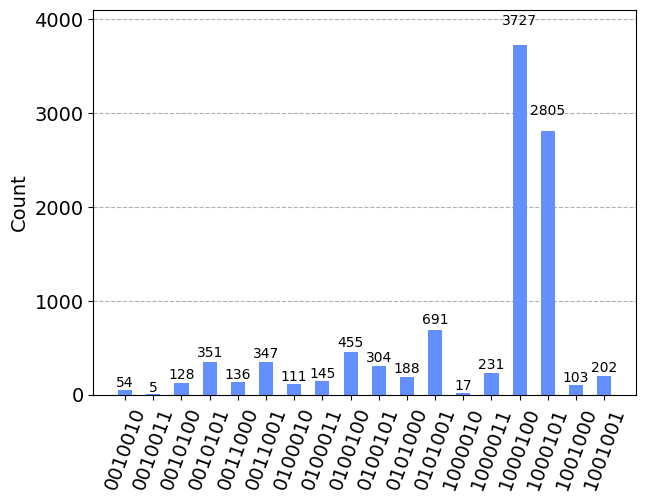

In [16]:
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x, n, m, l, K1, P, p)
# sorted_dict = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [20]:
expectation = 0
bitstring = "1000100"
z_h = np.array([int(bit) for bit in bitstring[(n*m):]])
x_ij = np.array([int(bit) for bit in bitstring[:(n*m)]]).reshape(n, m)

E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
E3 = 0
e1=0
e2=0
for j in range(m):

    sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

    sum_zh = np.sum([2**h * z_h[h] for h in range(l)])

    max_value = max(0, sum_xp - sum_zh)
    e1+=sum_xp
    e2+=sum_zh
    E3 += P * (max_value)**2
E =  E1 + E2 + E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

0
0
10
